# Model Comparison
Test out different potential models, as well as the possibility of fitting CDSOM using maximum likelihood approach.

Assume that observations for a year are provided as a data frame with a column for doy, a column for tmax, a column for tmin, and a column for dayl.

In [30]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

In [3]:
def accumulate_daily_observations(df, year, sos, method='independent', k=1):
    # Calculate average temperature
    df['tavg'] = (df['tmax'] + df['tmin'])/2

    # Compute number of cold days starting from previous year start of winter to start of season
    ncd_mask = (df['year'] == year-1) | (df['doy'] <= sos)
    ncd = (df.loc[ncd_mask, 'tavg'] < 5).sum()

    # Compute growing degree days starting from start of this year to start of season
    gdd_mask = (df['year'] == year) & (df['doy'] <= sos)
    df['gdd'] = (df.loc[gdd_mask, 'tavg'])*(df.loc[gdd_mask, 'tavg'] > 0)
    if method == 'independent':
        gdd = df['gdd'].sum()
    elif method == 'daylength':
        # Some method modulate gdd accumulation by the proportion of day that is light.
        gdd = (df['gdd']*((df['dayl']/86400.)**k)).sum()
    else:
        raise f"Invalid method selected: {method}."

    return ncd, gdd

In [4]:
# quick test of accumulation function
df = pd.DataFrame(data={'year':[2019, 2019, 2019, 2020, 2020, 2020, 2020],
                        'doy':[200, 250, 300, 10, 24, 50, 70],
                        'tmax':[10, 5, 0, -5, -10, 20, 40],
                        'tmin':[8, 3, 0, -7, -12, 18, 38],
                        'dayl':[12, 10, 8, 9, 10, 11, 12]})
print("Independent:", accumulate_daily_observations(df, 2020, 80))
print("Day length, k = 1:", accumulate_daily_observations(df, 2020, 80, method='daylength'))
print("Day length, k = 0.5:", accumulate_daily_observations(df, 2020, 80, method='daylength', k=0.5))

Independent: (np.int64(4), np.float64(58.0))
Day length, k = 1: (np.int64(4), np.float64(0.007835648148148147))
Day length, k = 0.5: (np.int64(4), np.float64(0.6740037545602604))


In [5]:
def AT_model(x, a, b, c):
    return a + b*torch.exp(-c*x)

def fit_AT_model(X, y, a_init, b_init, c_init, num_epochs=50, report_freq=10):
    a = torch.tensor(a_init, requires_grad=True, dtype=float)
    b = torch.tensor(b_init, requires_grad=True, dtype=float)
    c = torch.tensor(c_init, requires_grad=True, dtype=float)

    optimizer = torch.optim.Adam([a, b, c], lr=0.01)

    for epoch in range(num_epochs):
        pred = AT_model(X, a, b, c)
        loss = torch.sum((pred - y)**2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % report_freq == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

    return a, b, c

In [6]:
X = torch.tensor([100, 200, 300, 400, 500], dtype=float)
y = torch.tensor([1, 2, 3, 4, 5], dtype=float)
a, b, c = fit_AT_model(X, y, 1, 1, 0.01, num_epochs=450, report_freq=150)

Epoch [0/450], Loss: 29.5229
Epoch [150/450], Loss: 16.4620
Epoch [300/450], Loss: 11.0077


In [7]:
AT_model(X, a, b, c)

tensor([2.8831, 2.8731, 2.8730, 2.8730, 2.8730], dtype=torch.float64,
       grad_fn=<AddBackward0>)

## Testing out model at specific location

In [8]:
df = pd.read_csv("../data/local_sample.csv")
df['id'] = df['system:index'].str.split("_").str.get(2)
df['date'] = pd.to_datetime(df['system:index'].str.split("_").str.get(1), format="%Y%m%d")
df['doy'] = df['date'].dt.dayofyear
df = df[df['year'] < 2024].copy()

In [9]:
df.head()

,system:index,dayl,doy,tmax,tmin,year,.geo,id,date
0,"0_20001101_29007,11601_0",36260.61,306,14.52,-3.51,2000,"{""type"":""MultiPoint"",""coordinates"":[]}","29007,11601",2000-11-01
1,"0_20001101_29008,11601_0",36260.61,306,14.52,-3.52,2000,"{""type"":""MultiPoint"",""coordinates"":[]}","29008,11601",2000-11-01
2,"0_20001101_29016,11601_0",36260.61,306,14.33,-3.57,2000,"{""type"":""MultiPoint"",""coordinates"":[]}","29016,11601",2000-11-01
3,"0_20001101_29018,11601_0",36260.61,306,14.31,-3.58,2000,"{""type"":""MultiPoint"",""coordinates"":[]}","29018,11601",2000-11-01
4,"0_20001101_29010,11602_0",36260.61,306,14.60,-3.54,2000,"{""type"":""MultiPoint"",""coordinates"":[]}","29010,11602",2000-11-01


In [10]:
df_phen = pd.read_csv("../data/local_phen.csv")
df_phen['id'] = df_phen['system:index'].str.split("_").str.get(1)
df_phen

,system:index,SOS,year,.geo,id
0,"0_29004,11601_0",110.0,2001,"{""type"":""MultiPoint"",""coordinates"":[]}","29004,11601"
1,"0_29005,11601_0",112.0,2001,"{""type"":""MultiPoint"",""coordinates"":[]}","29005,11601"
2,"0_29006,11601_0",115.0,2001,"{""type"":""MultiPoint"",""coordinates"":[]}","29006,11601"
3,"0_29007,11601_0",112.0,2001,"{""type"":""MultiPoint"",""coordinates"":[]}","29007,11601"
4,"0_29008,11601_0",109.0,2001,"{""type"":""MultiPoint"",""coordinates"":[]}","29008,11601"
...,...,...,...,...,...
5649,"23_29004,11614_0",95.0,2024,"{""type"":""MultiPoint"",""coordinates"":[]}","29004,11614"
5650,"23_29005,11614_0",109.0,2024,"{""type"":""MultiPoint"",""coordinates"":[]}","29005,11614"
5651,"23_29006,11614_0",111.0,2024,"{""type"":""MultiPoint"",""coordinates"":[]}","29006,11614"
5652,"23_29007,11614_0",109.0,2024,"{""type"":""MultiPoint"",""coordinates"":[]}","29007,11614"


In [11]:
pixel_years = df[df['doy'] == 1].sample(100)

In [12]:
ncds = []
gdds = []
for py in pixel_years.itertuples():
    mask = (df['date'] >= pd.Timestamp(py.year-1, 11, 1)) & (df['date'] <= pd.Timestamp(py.year, 8, 1)) & (df['id'] == py.id)
    sos = df_phen.loc[(df_phen['id'] == py.id) & (df_phen['year'] == py.year), 'SOS'].iloc[0]
    ncd, gdd = accumulate_daily_observations(df[mask].copy(), py.year, sos, method='daylength', k=0.7)
    if (ncd < 60):
        continue
    ncds.append(ncd)
    gdds.append(gdd)
ncds = torch.tensor(ncds, dtype=float)
gdds = torch.tensor(gdds, dtype=float)

In [13]:
a, b, c = fit_AT_model(ncds, gdds, -1.73855049e+02, 1.81636712e+03, 1.02238340e-02, num_epochs=40000, report_freq=5000)

Epoch [0/40000], Loss: 1997264.6344
Epoch [5000/40000], Loss: 7802396.9293
Epoch [10000/40000], Loss: 5377936.2726
Epoch [15000/40000], Loss: 3437778.5208
Epoch [20000/40000], Loss: 2093221.4745
Epoch [25000/40000], Loss: 1076712.2417


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

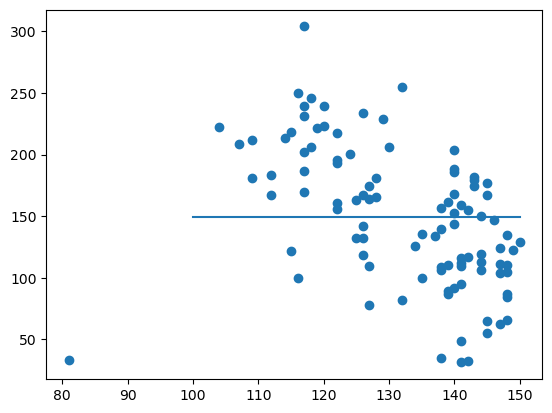

In [ ]:
fig, ax = plt.subplots()

ax.scatter(ncds, gdds)

x = torch.tensor([100., 150.])
ax.plot(x, AT_model(x, a, b, c).detach().numpy())

In [ ]:
a, b, c

(tensor(149.1049, dtype=torch.float64, requires_grad=True),
 tensor(1812.0758, dtype=torch.float64, requires_grad=True),
 tensor(0.5212, dtype=torch.float64, requires_grad=True))

In [ ]:
from scipy.optimize import curve_fit
import numpy as np

In [ ]:
def AT_model(x, a, b, c):
    return a + b*np.exp(-c*x)

In [ ]:
popt, _ = curve_fit(AT_model, ncds, gdds, [-68, 638, 0.01], maxfev=10000)

C:\Users\camer\AppData\Local\Temp\ipykernel_25120\1977507906.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return a + b*np.exp(-c*x)


C:\Users\camer\AppData\Local\Temp\ipykernel_25120\1977507906.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return a + b*np.exp(-c*x)


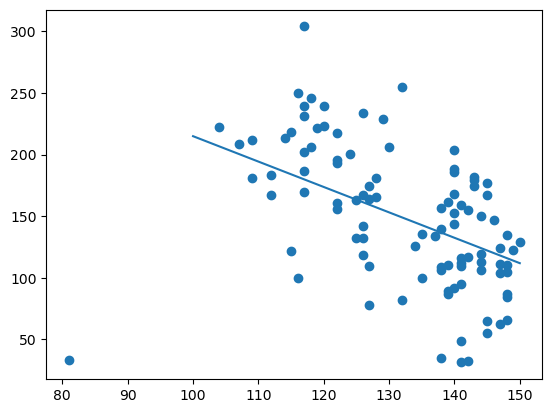

In [ ]:
fig, ax = plt.subplots()

ax.scatter(ncds, gdds)

x = torch.tensor([100., 150.])
ax.plot(x, AT_model(x, *popt).detach().numpy())

In [ ]:
popt

array([-4.85689581e+05,  4.86110827e+05,  4.24420480e-06])

In [ ]:
def predict_budbreak(df, year, a, b, c):
    for i in range(0, 150):
        gdd, ncd = accumulate_daily_observations(df, year, i)
        gdd_crit = AT_model(ncd, a, b, c)
        if (gdd >= gdd_crit):
            return i

In [17]:
all_pixel_years = df[df['doy'] == 1].copy()

In [ ]:
soss = []
preds = []
for py in all_pixel_years.itertuples():
    mask = (df['date'] >= pd.Timestamp(py.year-1, 11, 1)) & (df['date'] <= pd.Timestamp(py.year, 8, 1)) & (df['id'] == py.id)
    soss.append(df_phen.loc[(df_phen['id'] == py.id) & (df_phen['year'] == py.year), 'SOS'].iloc[0])
    preds.append(predict_budbreak(df[mask].copy(), py.year, *popt))
soss = np.array(soss)
preds = np.array(preds)

KeyboardInterrupt: 

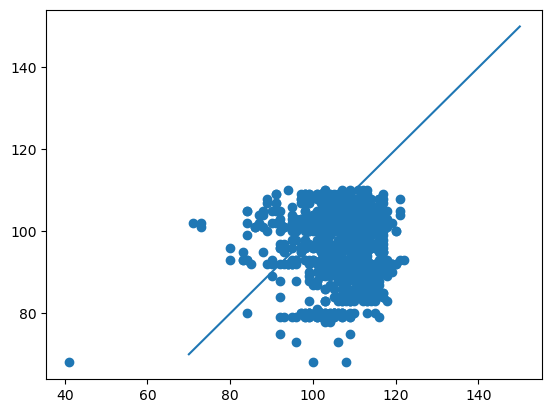

In [ ]:
fig, ax = plt.subplots()

ax.scatter(soss, preds)

ax.plot([70, 150], [70, 150])

In [ ]:
np.sqrt(np.mean((soss-preds)**2))

np.float64(15.081071617652617)

## Attempting to fit a CDSOM model

In [107]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.best_params = []

    def early_stop(self, validation_loss, params):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            self.best_params = [p.detach().clone() for p in params]
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [66]:
all_pixel_years = df[df['doy'] == 1].copy()
train = all_pixel_years.sample(300)
test = all_pixel_years.drop(train.index)

In [67]:
def create_dataset(samples, df):
    ## Convert pixel year data into individual tensors
    tavgs = []
    dayls = []
    cus = []
    soss = []
    for py in samples.itertuples():
        mask = (df['date'] >= pd.Timestamp(py.year-1, 11, 1)) & (df['date'] <= pd.Timestamp(py.year, 8, 1)) & (df['id'] == py.id)
        test_year = df[mask].copy()
        test_year['tavg'] = (test_year['tmax'] + test_year['tmin'])/2
        test_year = test_year.sort_values(by='date')
        sos = df_phen.loc[(df_phen['id'] == py.id) & (df_phen['year'] == py.year), 'SOS'].iloc[0]
        tavgs_py = []
        dayls_py = []
        cus_py = [np.count_nonzero(test_year.loc[test_year['year'] == py.year-1, 'tavg'] < 5)]
        test_year = test_year[test_year['year'] == py.year]
        for row in test_year.itertuples():
            tavgs_py.append((row.tmax + row.tmin)/2)
            dayls_py.append(row.dayl/86_400)
            cus_py.append(cus_py[-1] + (tavgs_py[-1]<5))
        cus_py = cus_py[1:]

        # Drop last observation for leap years
        if len(tavgs_py) == 182:
            tavgs_py = tavgs_py[:-1]
            dayls_py = dayls_py[:-1]
            cus_py = cus_py[:-1]

        tavgs.append(tavgs_py)
        dayls.append(dayls_py)
        cus.append(cus_py)
        soss.append(sos)
        
    tavgs = torch.tensor(tavgs, dtype=float)
    dayls = torch.tensor(dayls, dtype=float)
    cus = torch.tensor(cus, dtype=float)
    soss = torch.tensor(soss, dtype=float)
    actual = torch.arange(0, 181, dtype=float).repeat(tavgs.shape[0], 1)
    actual = torch.tensor(actual >= soss.reshape(-1, 1).repeat(1, 181), dtype=float)
    return tavgs, dayls, cus, soss, actual

In [84]:
tavgs_train, dayls_train, cus_train, soss_train, actual_train = create_dataset(train, df)
tavgs_test, dayls_test, cus_test, soss_test, actual_test = create_dataset(test, df)

C:\Users\camer\AppData\Local\Temp\ipykernel_33384\3357605185.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actual = torch.tensor(actual >= soss.reshape(-1, 1).repeat(1, 181), dtype=float)
C:\Users\camer\AppData\Local\Temp\ipykernel_33384\3357605185.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actual = torch.tensor(actual >= soss.reshape(-1, 1).repeat(1, 181), dtype=float)


In [106]:
def make_prediction(tavgs, dayls, cus, b_tavg, b_dayl, b_cu, lam, kappa):
    forcings = tavgs*b_tavg + dayls*b_dayl + cus*b_cu
    hss= []
    hs = torch.zeros(tavgs.shape[0])
    for i in range(tavgs.shape[1]):
        dhs = forcings[:, i]*(1 - hs/100.)
        dhs = torch.maximum(dhs, torch.tensor(0, dtype=float))
        hs = hs + dhs
        hss.append(hs)
    hss = torch.stack(hss, dim=1)

    # Calculate cumulative probabilities
    probs = 1 / (torch.exp(-(kappa + lam*hss)) + 1)
    p = probs[:,0]
    ps = [p]
    dailys = [p]
    for i in range(1, probs.shape[1]):
        p = probs[:, i]*(1-p) + p
        ps.append(p)
        dailys.append(probs[:, i]*(1-p))
    pred = torch.stack(ps, dim=1)
    dailys = torch.stack(dailys)

    return pred, dailys

In [108]:
b_tavg_lsq = torch.tensor(1, requires_grad=True, dtype=float)
b_dayl_lsq = torch.tensor(1, requires_grad=True, dtype=float)
b_cu_lsq = torch.tensor(0.1, requires_grad=True, dtype=float)
kappa_lsq = torch.tensor(-8, requires_grad=True, dtype=float)
lam_lsq = torch.tensor(0.1, requires_grad=True, dtype=float)

optimizer = torch.optim.Adam([b_tavg_lsq, b_dayl_lsq, b_cu_lsq, kappa_lsq, lam_lsq], lr=0.01)
early_stopper = EarlyStopper(50, 5)
num_epochs = 2000
report_freq = 50
for epoch in range(num_epochs):
    pred, _ = make_prediction(tavgs_train, dayls_train, cus_train, 
                              b_tavg_lsq, b_dayl_lsq, b_cu_lsq, lam_lsq, kappa_lsq)

    loss = torch.sum((pred - actual_train)**2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if early_stopper.early_stop(loss, [b_tavg_lsq, b_dayl_lsq, b_cu_lsq, kappa_lsq, lam_lsq]):
        print('Stopping early, loss is not decreasing.')
        break

    if epoch % report_freq == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/2000], Loss: 22855.1132
Epoch [51/2000], Loss: 2486.4382
Epoch [101/2000], Loss: 2358.5238
Epoch [151/2000], Loss: 2256.1512
Epoch [201/2000], Loss: 2087.9754
Epoch [251/2000], Loss: 1829.2457
Epoch [301/2000], Loss: 1754.3587
Epoch [351/2000], Loss: 1624.8224
Epoch [401/2000], Loss: 1591.6158
Epoch [451/2000], Loss: 1633.0209
Epoch [501/2000], Loss: 1484.5961
Epoch [551/2000], Loss: 1518.6573
Epoch [601/2000], Loss: 1416.9303
Epoch [651/2000], Loss: 1417.9223
Epoch [701/2000], Loss: 1485.3645
Epoch [751/2000], Loss: 1353.6124
Epoch [801/2000], Loss: 1361.4324
Epoch [851/2000], Loss: 1376.0970
Epoch [901/2000], Loss: 1321.0192
Epoch [951/2000], Loss: 1317.5167
Epoch [1001/2000], Loss: 1333.6245
Epoch [1051/2000], Loss: 1315.5075
Epoch [1101/2000], Loss: 1316.9880
Epoch [1151/2000], Loss: 1416.2249
Epoch [1201/2000], Loss: 1290.8872
Epoch [1251/2000], Loss: 1342.2219
Epoch [1301/2000], Loss: 1316.5993
Epoch [1351/2000], Loss: 1345.8875
Stopping early, loss is not decreasing.
St

In [111]:
b_tavg_lsq = early_stopper.best_params[0]
b_dayl_lsq = early_stopper.best_params[1]
b_cu_lsq = early_stopper.best_params[2]
kappa_lsq = early_stopper.best_params[3]
lam_lsq = early_stopper.best_params[4]

In [109]:
print(f"Kappa: {kappa_lsq.item()}")
print(f"Lambda: {lam_lsq.item()}")
print(f"B_tavg: {b_tavg_lsq.item()}")
print(f"B_dayl: {b_dayl_lsq.item()}")
print(f"B_cu: {b_cu_lsq.item()}")

Kappa: -9.248356075040087
Lambda: 0.23451563675915882
B_tavg: 0.08818348076312679
B_dayl: -2.1645120535362232
B_cu: 0.01224475014743528


In [112]:
pred, dailys = make_prediction(tavgs_test, dayls_test, cus_test, 
                               b_tavg_lsq, b_dayl_lsq, b_cu_lsq, lam_lsq, kappa_lsq)

In [147]:
# Compute "Confidence Inteval"
min_ci = torch.argmax(torch.tensor(pred > 0.25, dtype=float), dim=1)
max_ci = torch.argmax(torch.tensor(pred > 0.75, dtype=float), dim=1)

C:\Users\camer\AppData\Local\Temp\ipykernel_33384\3826028890.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  min_ci = torch.argmax(torch.tensor(pred > 0.25, dtype=float), dim=1)
C:\Users\camer\AppData\Local\Temp\ipykernel_33384\3826028890.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_ci = torch.argmax(torch.tensor(pred > 0.75, dtype=float), dim=1)


102 112


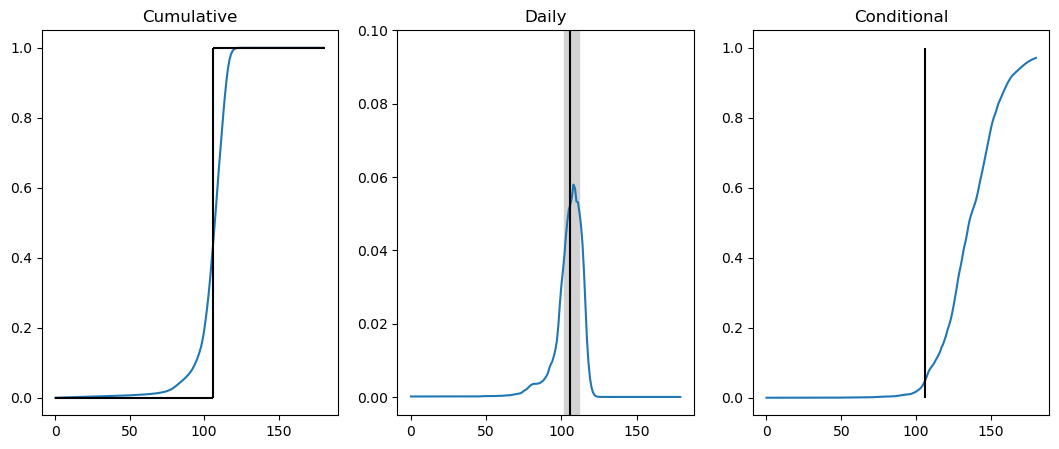

In [151]:
id = 400
p1 = list(pred[id, :].detach())
daily = [p1[i+1]-p1[i] for i in range(len(p1)-1)]
#p3 = list(probs[id, :].detach())

fig, axes = plt.subplots(ncols=3, figsize=(13,5))
axes[0].plot(p1)
axes[0].vlines(soss[id], 0, 1, color='black')
axes[0].hlines(0, 0, soss[id], color='black')
axes[0].hlines(1, soss[id], len(p1), color='black')

axes[1].plot(daily)
axes[1].vlines(soss[id], -0.005, 0.1, color='black')
axes[1].axvspan(min_ci[id].item(), max_ci[id].item(), color='lightgray')
axes[1].set_ylim(-0.005, 0.1)

axes[2].plot(p3)
axes[2].vlines(soss[id], 0, 1, color='black')

#axes[3].plot(hss[id, :].detach())

axes[0].set_title('Cumulative')
axes[1].set_title('Daily')
axes[2].set_title('Conditional')

print(min_ci[id].item(), max_ci[id].item())

Text(0.5, 1.0, 'CU')

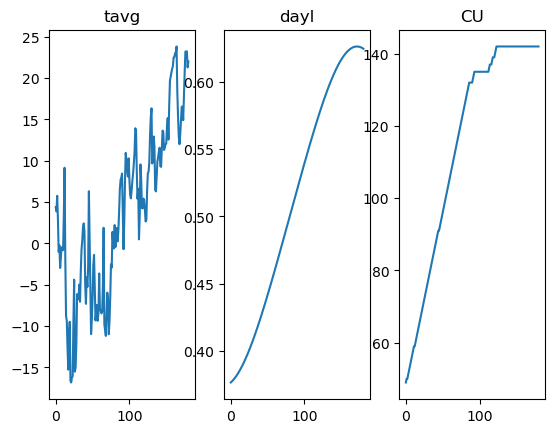

In [150]:
fig, axes = plt.subplots(ncols=3)
axes[0].plot(tavgs_test[id, :])
axes[1].plot(dayls_test[id, :])
axes[2].plot(cus_test[id, :])

axes[0].set_title('tavg')
axes[1].set_title('dayl')
axes[2].set_title('CU')

## Predict sos as the max of daily probabilities

In [115]:
pred_sos = torch.argmax(dailys, dim=0)

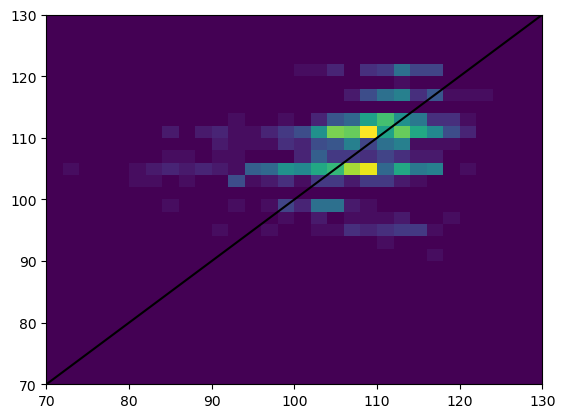

In [116]:
fig, ax = plt.subplots()

ax.hist2d(soss_test.detach(), pred_sos.detach(), range=[[70, 130], [70, 130]], bins=30)
ax.set_xlim(70, 130)
ax.set_ylim(70, 130)
ax.plot([70, 130], [70, 130], color='black')

In [117]:
torch.sqrt(torch.mean((pred_sos - soss_test)**2))

tensor(7.9823, dtype=torch.float64)

## Predict SOS as 50% probability point

In [118]:
pred_sos = torch.argmax(torch.tensor(pred > 0.5, dtype=float), dim=1)

C:\Users\camer\AppData\Local\Temp\ipykernel_33384\1623465876.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_sos = torch.argmax(torch.tensor(pred > 0.5, dtype=float), dim=1)


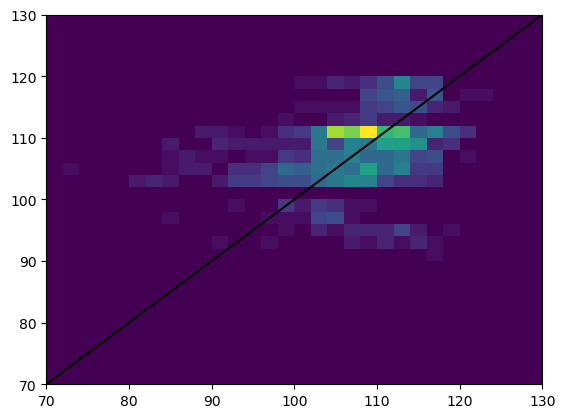

In [119]:
fig, ax = plt.subplots()

ax.hist2d(soss_test.detach(), pred_sos.detach(), range=[[70, 130], [70, 130]], bins=30)
ax.set_xlim(70, 130)
ax.set_ylim(70, 130)
ax.plot([70, 130], [70, 130], color='black')

In [120]:
torch.sqrt(torch.mean((pred_sos - soss_test)**2))

tensor(7.9182, dtype=torch.float64)

# Changing Loss Functions

In [127]:
b_tavg_bce = torch.tensor(1, requires_grad=True, dtype=float)
b_dayl_bce = torch.tensor(1, requires_grad=True, dtype=float)
b_cu_bce = torch.tensor(0.1, requires_grad=True, dtype=float)
kappa_bce = torch.tensor(-8, requires_grad=True, dtype=float)
lam_bce = torch.tensor(0.1, requires_grad=True, dtype=float)

optimizer = torch.optim.Adam([b_tavg_bce, b_dayl_bce, b_cu_bce, kappa_bce, lam_bce], lr=0.01)
early_stopper = EarlyStopper(50, 0.05)
num_epochs = 2000
report_freq = 50
for epoch in range(num_epochs):
    pred, _ = make_prediction(tavgs_train, dayls_train, cus_train, 
                              b_tavg_bce, b_dayl_bce, b_cu_bce, lam_bce, kappa_bce)

    loss = -1*torch.mean(actual_train*torch.log(pred+1e-15) + (1-actual_train)*torch.log(1-pred+1e-15))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if early_stopper.early_stop(loss, [b_tavg_bce, b_dayl_bce, b_cu_bce, kappa_bce, lam_bce]):
        print('Stopping early, loss is not decreasing.')
        break

    if epoch % report_freq == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/2000], Loss: 10.4592
Epoch [51/2000], Loss: 0.2046
Epoch [101/2000], Loss: 0.1529
Epoch [151/2000], Loss: 0.1505
Epoch [201/2000], Loss: 0.1481
Epoch [251/2000], Loss: 0.1452
Epoch [301/2000], Loss: 0.1413
Epoch [351/2000], Loss: 0.1361
Epoch [401/2000], Loss: 0.1293
Epoch [451/2000], Loss: 0.1224
Epoch [501/2000], Loss: 0.1184
Epoch [551/2000], Loss: 0.1152
Epoch [601/2000], Loss: 0.1123
Epoch [651/2000], Loss: 0.1093
Epoch [701/2000], Loss: 0.1062
Epoch [751/2000], Loss: 0.1033
Epoch [801/2000], Loss: 0.1020
Epoch [851/2000], Loss: 0.0988
Epoch [901/2000], Loss: 0.1217
Epoch [951/2000], Loss: 0.0959
Epoch [1001/2000], Loss: 0.0938
Epoch [1051/2000], Loss: 0.0922
Epoch [1101/2000], Loss: 0.0962
Epoch [1151/2000], Loss: 0.0900
Epoch [1201/2000], Loss: 0.0888
Epoch [1251/2000], Loss: 0.1167
Epoch [1301/2000], Loss: 0.0875
Epoch [1351/2000], Loss: 0.0866
Epoch [1401/2000], Loss: 0.0859
Epoch [1451/2000], Loss: 0.0855
Epoch [1501/2000], Loss: 0.0851
Epoch [1551/2000], Loss: 0.084

In [128]:
b_tavg_bce = early_stopper.best_params[0]
b_dayl_bce = early_stopper.best_params[1]
b_cu_bce = early_stopper.best_params[2]
kappa_bce = early_stopper.best_params[3]
lam_bce = early_stopper.best_params[4]

print(f"Kappa: {kappa_bce.item()}")
print(f"Lambda: {lam_bce.item()}")
print(f"B_tavg: {b_tavg_bce.item()}")
print(f"B_dayl: {b_dayl_bce.item()}")
print(f"B_cu: {b_cu_bce.item()}")

Kappa: -9.013930766774674
Lambda: 0.18231768529028367
B_tavg: 0.10202023881927219
B_dayl: -2.420312597162175
B_cu: 0.013837080046014746


In [137]:
early_stopper.min_validation_loss

tensor(0.0828, dtype=torch.float64, grad_fn=<MulBackward0>)

In [130]:
pred, dailys = make_prediction(tavgs_test, dayls_test, cus_test, 
                               b_tavg_bce, b_dayl_bce, b_cu_bce, lam_bce, kappa_bce)

## Predict sos as the max of daily probabilities

In [131]:
pred_sos = torch.argmax(dailys, dim=0)

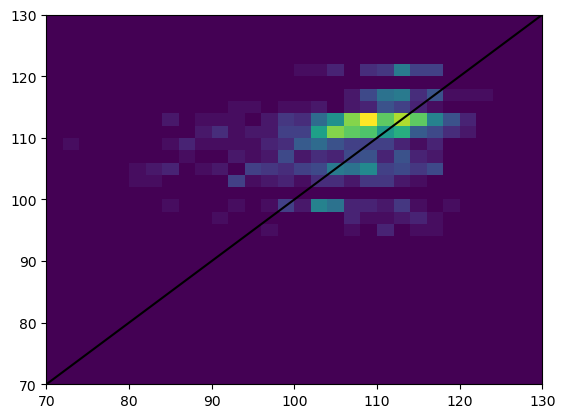

In [132]:
fig, ax = plt.subplots()

ax.hist2d(soss_test.detach(), pred_sos.detach(), range=[[70, 130], [70, 130]], bins=30)
ax.set_xlim(70, 130)
ax.set_ylim(70, 130)
ax.plot([70, 130], [70, 130], color='black')

In [133]:
torch.sqrt(torch.mean((pred_sos - soss_test)**2))

tensor(8.2664, dtype=torch.float64)

## Predict SOS as 50% probability point

In [134]:
pred_sos = torch.argmax(torch.tensor(pred > 0.5, dtype=float), dim=1)

C:\Users\camer\AppData\Local\Temp\ipykernel_33384\1623465876.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_sos = torch.argmax(torch.tensor(pred > 0.5, dtype=float), dim=1)


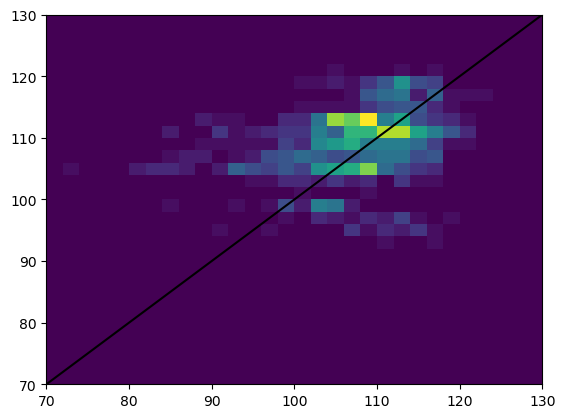

In [135]:
fig, ax = plt.subplots()

ax.hist2d(soss_test.detach(), pred_sos.detach(), range=[[70, 130], [70, 130]], bins=30)
ax.set_xlim(70, 130)
ax.set_ylim(70, 130)
ax.plot([70, 130], [70, 130], color='black')

In [136]:
torch.sqrt(torch.mean((pred_sos - soss_test)**2))

tensor(8.0719, dtype=torch.float64)